In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import datetime

In [2]:
import jqdatasdk as jq
jq.auth('13061909965', '12345Qaz')

auth success 


In [3]:
start_date = '2015-01-01'
end_date = '2021-08-31'

In [4]:
stock=jq.get_index_stocks('000905.XSHG', date=None)
len(stock)

500

In [5]:
b=[]
for i in range(len(stock)):
    if jq.get_security_info(stock[i]).start_date<=datetime.date(2010, 1, 1):
        b.append(stock[i])
    i=i+1

In [6]:
len(b)

294

In [7]:
df=np.array(jq.get_price(stock[0], start_date, end_date, 'daily',['close'],panel=False))
len(df)

1624

In [8]:
s=b

In [9]:
len(s)

294

In [10]:
s

['000009.XSHE',
 '000012.XSHE',
 '000021.XSHE',
 '000027.XSHE',
 '000028.XSHE',
 '000031.XSHE',
 '000039.XSHE',
 '000046.XSHE',
 '000050.XSHE',
 '000060.XSHE',
 '000062.XSHE',
 '000089.XSHE',
 '000090.XSHE',
 '000156.XSHE',
 '000158.XSHE',
 '000400.XSHE',
 '000401.XSHE',
 '000402.XSHE',
 '000415.XSHE',
 '000488.XSHE',
 '000513.XSHE',
 '000519.XSHE',
 '000528.XSHE',
 '000537.XSHE',
 '000540.XSHE',
 '000547.XSHE',
 '000553.XSHE',
 '000559.XSHE',
 '000563.XSHE',
 '000581.XSHE',
 '000598.XSHE',
 '000623.XSHE',
 '000629.XSHE',
 '000630.XSHE',
 '000636.XSHE',
 '000656.XSHE',
 '000671.XSHE',
 '000685.XSHE',
 '000686.XSHE',
 '000690.XSHE',
 '000709.XSHE',
 '000717.XSHE',
 '000718.XSHE',
 '000723.XSHE',
 '000728.XSHE',
 '000729.XSHE',
 '000733.XSHE',
 '000738.XSHE',
 '000739.XSHE',
 '000750.XSHE',
 '000758.XSHE',
 '000778.XSHE',
 '000807.XSHE',
 '000825.XSHE',
 '000830.XSHE',
 '000869.XSHE',
 '000877.XSHE',
 '000878.XSHE',
 '000883.XSHE',
 '000887.XSHE',
 '000898.XSHE',
 '000930.XSHE',
 '000932

In [11]:

#Generate F(y) Compute the gradient


def my_gradient(y_input, lamb, p_input, b_0, n):
    f = 0.0
    Fy = np.zeros((n, 1))
    p_input_copy = (p_input.copy()).transpose()
    for i in range(0,n):
        p_input_copy[i, :] = ((np.maximum(lamb[i],0).astype(float))**0.5)*p_input_copy[i, :]

    for i in range(0,n):
        Fy[i] = np.sum(p_input_copy[:, i]*p_input_copy[:, i])

    for i in range(0,n):
        f = f + np.square((np.maximum(lamb[i],0)))

    f = 0.5*f - np.dot(b_0.transpose(), y_input)

    return f, Fy


# use PCA to generate a primal feasible solution checked

def my_pca(x_input, lamb, p_input, b_0, n):
    x_pca = x_input
    lamb = np.asarray(lamb)
    lp = lamb > 0
    r = lamb[lp].size
    if r == 0:
        x_pca = np.zeros((n, n))
    elif r == n:
        x_pca = x_input
    elif r<(n/2.0):
        lamb1 = lamb[lp].copy()
        lamb1 = lamb1.transpose()
        lamb1 = np.sqrt(lamb1.astype(float))
        P1 = p_input[:, 0:r].copy()
        if r>1:
            P1 = np.dot(P1,np.diagflat(lamb1))
            x_pca = np.dot(P1, P1.transpose())
        else:
            x_pca = np.dot(np.dot(np.square(lamb1), P1), P1.transpose())

    else:
        lamb2 = -lamb[r:n].copy()
        lamb2 = np.sqrt(lamb2.astype(float))
        p_2 = p_input[:, r:n]
        p_2 = np.dot(p_2,np.diagflat(lamb2))
        x_pca = x_pca + np.dot(p_2, p_2.transpose())

    # To make x_pca positive semidefinite with diagonal elements exactly b0
    d = x_pca.diagonal()
    d = d.reshape((d.size, 1))
    d = np.maximum(d, b_0.reshape(d.shape))
    x_pca = x_pca - np.diagflat(x_pca.diagonal()) + np.diagflat(d)
    d = d.astype(float)**(-0.5)
    d = d*((np.sqrt(b_0.astype(float))).reshape(d.shape))
    x_pca = x_pca*(np.dot(d, d.reshape(1, d.size)))

    return x_pca
# end of PCA

#To generate the first order difference of lambda
# To generate the first order essential part of d


def my_omega_mat(p_input, lamb, n):
    idx_idp = np.where(lamb > 0)
    idx_idp = idx_idp[0]
    idx_idm = np.setdiff1d(range(0, n), idx_idp)
    n = lamb.size
    r = idx_idp.size
    if r > 0:
        if r == n:
            omega_12 = np.ones((n, n))
        else:
            s = n - r
            dp = lamb[0:r].copy()
            dp = dp.reshape(dp.size, 1)
            dn = lamb[r:n].copy()
            dn = dn.reshape((dn.size, 1))
            omega_12 = np.dot(dp, np.ones((1, s)))
            omega_12 = omega_12/(np.dot(np.abs(dp), np.ones((1,s))) + np.dot(np.ones((r,1)), abs(dn.transpose())))
            omega_12 = omega_12.reshape((r, s))

    else:
        omega_12 = np.array([])

    return omega_12

# End of my_omega_mat


# To generate Jacobian


def my_jacobian_matrix(x, omega_12, p_input, n):
    x_result = np.zeros((n,1))
    [r, s] = omega_12.shape
    if r > 0:
        hmat_1 = p_input[:, 0:r].copy()
        if r < n/2.0:
            i=0
            while i<n:
                hmat_1[i,:] = x[i]*hmat_1[i,:]
                i = i+1

            omega_12 = omega_12*(np.dot(hmat_1.transpose(), p_input[:, r:n]))
            hmat = np.dot(hmat_1.transpose(),np.dot(p_input[:, 0:r], p_input[:, 0:r].transpose()))
            hmat = hmat + np.dot(omega_12, p_input[:, r:n].transpose())
            hmat = np.vstack((hmat, np.dot(omega_12.transpose(), p_input[:, 0:r].transpose())))
            i = 0
            while i<n:
                x_result[i] = np.dot(p_input[i, :], hmat[:, i])
                x_result[i] = x_result[i] + 1.0e-10*x[i]
                i = i+1

        else:
            if r==n:
                x_result = 1.0e-10*x
            else:
                hmat_2 = p_input[:, r:n].copy()
                i=0
                while i<n:
                    hmat_2[i, :] = x[i]*hmat_2[i, :]
                    i = i+1

                omega_12 = np.ones((r, s)) - omega_12
                omega_12 = omega_12*(np.dot(p_input[:, 0:r].transpose(), hmat_2))
                hmat = np.dot(p_input[:, r:n].transpose(), hmat_2)
                hmat = np.dot(hmat, p_input[:, r:n].transpose())
                hmat = hmat + np.dot(omega_12.transpose(),p_input[:, 0:r].transpose())
                hmat = np.vstack((np.dot(omega_12, p_input[:, r:n].transpose()), hmat))
                i=0
                while i<n:
                    x_result[i] = np.dot(-p_input[i,:], hmat[:, i])
                    x_result[i] = x[i] + x_result[i] + 1.0e-10*x[i]
                    i = i+1

    return x_result

#end of Jacobian
# PCG Method


def my_pre_cg(b, tol, maxit, c, omega_12, p_input, n):
    #Initializations
    r = b.copy()
    r = r.reshape(r.size, 1)
    c = c.reshape(c.size, 1)
    n2b = np.linalg.norm(b)
    tolb = tol*n2b
    p = np.zeros((n, 1))
    flag = 1
    iterk = 0
    relres = 1000
    # Precondition
    z = r/c
    rz_1 = np.dot(r.transpose(), z)
    rz_2 = 1
    d = z.copy()
    #d = d.reshape(z.shape)
    # CG Iteration
    for k in range(0, maxit):
        if k > 0:
            beta = rz_1/rz_2
            d = z + beta*d

        w = my_jacobian_matrix(d, omega_12, p_input, n)
        denom = np.dot(d.transpose(), w)
        iterk = k+1
        relres = np.linalg.norm(r)/n2b
        if denom <= 0:
            ss = 0 # don't know the usage, check the paper
            p = d/np.linalg.norm(d)
            break
        else:
            alpha = rz_1/denom
            p = p + alpha*d
            r = r - alpha*w

        z = r/c
        if np.linalg.norm(r)<=tolb: #exit if hmat p = b solved in relative error tolerance
            iterk = k+1
            relres = np.linalg.norm(r)/n2b
            flag = 0
            break

        rz_2 = rz_1
        rz_1 = np.dot(r.transpose(), z)

    return p, flag, relres, iterk

# end of pre_cg

#to generate the diagonal preconditioner


def my_precond_matrix(omega_12, p_input, n):
    [r, s] = omega_12.shape
    c = np.ones((n, 1))
    if r > 0:
        if r < n/2.0:
            hmat = (p_input.copy()).transpose()
            hmat = hmat*hmat
            hmat_12 = np.dot(hmat[0:r, :].transpose(), omega_12)
            d = np.ones((r, 1))
            for i in range(0, n):
                c_temp = np.dot(d.transpose(), hmat[0:r, i])
                c_temp = c_temp*hmat[0:r, i]
                c[i] = np.sum(c_temp)
                c[i] = c[i] + 2.0*np.dot(hmat_12[i, :], hmat[r:n, i])
                if c[i] < 1.0e-8:
                    c[i] = 1.0e-8

        else:
            if r < n:
                hmat = (p_input.copy()).transpose()
                hmat = hmat*hmat
                omega_12 = np.ones((r,s)) - omega_12
                hmat_12 = np.dot(omega_12, hmat[r:n, :])
                d = np.ones((s, 1))
                dd = np.ones((n, 1))

                for i in range(0, n):
                    c_temp = np.dot(d.transpose(), hmat[r:n, i])
                    c[i] = np.sum(c_temp*hmat[r:n, i])
                    c[i] = c[i] + 2.0*np.dot(hmat[0:r, i].transpose(), hmat_12[:, i])
                    alpha = np.sum(hmat[:, i])
                    c[i] = alpha*np.dot(hmat[:, i].transpose(), dd) - c[i]
                    if c[i] < 1.0e-8:
                        c[i] = 1.0e-8

    return c

# end of precond_matrix 


# my_issorted()

def my_issorted(x_input, flag):
    n = x_input.size
    tf_value = False
    if n < 2:
        tf_value = True
    else:
        if flag == 1:
            i = 0
            while i < n-1:
                if x_input[i] <= x_input[i+1]:
                    i = i+1
                else:
                    break

            if i == n-1:
                tf_value = True
            elif i < n-1:
                tf_value = False

        elif flag == -1:
            i = n-1
            while i > 0:
                if x_input[i] <= x_input[i-1]:
                    i = i-1
                else:
                    break

            if i == 0:
                tf_value = True
            elif i > 0:
                tf_value = False

    return tf_value

# end of my_issorted()


def my_mexeig(x_input):
    [n, m] = x_input.shape
    [lamb, p_x] = np.linalg.eigh(x_input)
    #lamb = lamb.reshape((lamb.size, 1))
    p_x = p_x.real
    lamb = lamb.real
    if my_issorted(lamb, 1):
        lamb = lamb[::-1]
        p_x = np.fliplr(p_x)
    elif my_issorted(lamb, -1):
        return p_x, lamb
    else:
        idx = np.argsort(-lamb)
       #lamb_old = lamb   # add for debug
        lamb = lamb[idx]
        #p_x_old = p_x   add for debug
        p_x = p_x[:, idx]

    lamb = lamb.reshape((n, 1))
    p_x = p_x.reshape((n, n))

    return p_x, lamb

# end of my_mymexeig()


# begin of the main function


def my_correlationmatrix(g_input, b_input=None, tau=None, tol=None):
    print ('-- Semismooth Newton-CG method starts -- \n')
    [n, m] = g_input.shape
    g_input = g_input.copy()
    t0 = time.perf_counter()    # time start
    g_input = (g_input + g_input.transpose())/2.0
    b_g = np.ones((n, 1))
    error_tol = 1.0e-6
    if b_input is None:
        tau = 0
    elif tau is None:
        b_g = b_input.copy()
        tau = 0
    elif tol is None:
        b_g = b_input.copy() - tau*np.ones((n, 1))
        g_input = g_input - tau*np.eye(n, n)
    else:
        b_g = b_input.copy() - tau*np.ones((n, 1))
        g_input = g_input - tau*np.eye(n, n)
        error_tol = np.maximum(1.0e-12, tol)

    res_b = np.zeros((300,1))
    norm_b0 = np.linalg.norm(b_g)
    y = np.zeros((n, 1))
    f_y = np.zeros((n, 1))
    k=0
    f_eval = 0
    iter_whole = 200
    iter_inner = 20 # maximum number of line search in Newton method
    maxit = 200 # maximum number of iterations in PCG
    iterk = 0
    inner = 0
    tol_cg = 1.0e-2 # relative accuracy for CGs
    sigma_1 = 1.0e-4
    x0 = y.copy()
    prec_time = 0
    pcg_time = 0
    eig_time = 0
    c = np.ones((n, 1))
    d = np.zeros((n, 1))
    val_g = np.sum((g_input.astype(float))*(g_input.astype(float)))
    val_g = val_g*0.5
    x_result = g_input + np.diagflat(y)
    x_result = (x_result + x_result.transpose())/2.0
    eig_time0 = time.perf_counter()
    [p_x, lamb] = my_mexeig(x_result)
    eig_time = eig_time + (time.perf_counter() - eig_time0)
    [f_0, f_y] = my_gradient(y, lamb, p_x, b_g, n)
    initial_f = val_g - f_0
    x_result = my_pca(x_result, lamb, p_x, b_g, n)
    val_obj = np.sum(((x_result - g_input)*(x_result - g_input)))/2.0
    gap = (val_obj - initial_f)/(1.0 + np.abs(initial_f) + np.abs(val_obj))
    f = f_0.copy()
    f_eval = f_eval + 1
    b_input = b_g - f_y
    norm_b = np.linalg.norm(b_input)
    time_used = time.perf_counter() - t0

    print ('Newton-CG: Initial Dual objective function value: %s \n' % initial_f)
    print ('Newton-CG: Initial Primal objective function value: %s \n' % val_obj)
    print ('Newton-CG: Norm of Gradient: %s \n' % norm_b)
    print ('Newton-CG: computing time used so far: %s \n' % time_used)

    omega_12 = my_omega_mat(p_x, lamb, n)
    x0 = y.copy()

    while np.abs(gap) > error_tol and norm_b/(1+norm_b0) > error_tol and k < iter_whole:
        prec_time0 = time.perf_counter()
        c = my_precond_matrix(omega_12, p_x, n)
        prec_time = prec_time + (time.perf_counter() - prec_time0)

        pcg_time0 = time.perf_counter()
        [d, flag, relres, iterk] = my_pre_cg(b_input, tol_cg, maxit, c, omega_12, p_x, n)
        pcg_time = pcg_time + (time.perf_counter() - pcg_time0)
        print ('Newton-CG: Number of CG Iterations=== %s \n' % iterk)
        if flag == 1:
            print ('=== Not a completed Newton-CG step === \n')

        slope = np.dot((f_y - b_g).transpose(), d)

        y = (x0 + d).copy()
        x_result = g_input + np.diagflat(y)
        x_result = (x_result + x_result.transpose())/2.0
        eig_time0 = time.perf_counter()
        [p_x, lamb] = my_mexeig(x_result)
        eig_time = eig_time + (time.perf_counter() - eig_time0)
        [f, f_y] = my_gradient(y, lamb, p_x, b_g, n)

        k_inner = 0
        while k_inner <= iter_inner and f > f_0 + sigma_1*(np.power(0.5, k_inner))*slope + 1.0e-6:
            k_inner = k_inner + 1
            y = x0 + (np.power(0.5, k_inner))*d
            x_result = g_input + np.diagflat(y)
            x_result = (x_result + x_result.transpose())/2.0
            eig_time0 = time.perf_counter()
            [p_x, lamb] = my_mexeig(x_result)
            eig_time = eig_time + (time.perf_counter() - eig_time0)
            [f, f_y] = my_gradient(y, lamb, p_x, b_g, n)

        f_eval = f_eval + k_inner + 1
        x0 = y.copy()
        f_0 = f.copy()
        val_dual = val_g - f_0
        x_result = my_pca(x_result, lamb, p_x, b_g, n)
        val_obj = np.sum((x_result - g_input)*(x_result - g_input))/2.0
        gap = (val_obj - val_dual)/(1 + np.abs(val_dual) + np.abs(val_obj))
        print ('Newton-CG: The relative duality gap: %s \n' % gap)
        print ('Newton-CG: The Dual objective function value: %s \n' % val_dual)
        print ('Newton-CG: The Primal objective function value: %s \n' % val_obj)

        b_input = b_g - f_y
        norm_b = np.linalg.norm(b_input)
        time_used = time.perf_counter() - t0
        rel_norm_b = norm_b/(1+norm_b0)
        print ('Newton-CG: Norm of Gradient: %s \n' % norm_b)
        print ('Newton-CG: Norm of Relative Gradient: %s \n' %  rel_norm_b)
        print ('Newton-CG: Computing time used so for %s \n' % time_used)
        res_b[k] = norm_b
        k = k + 1
        omega_12 = my_omega_mat(p_x, lamb, n)

    position_rank = np.maximum(lamb, 0)>0
    rank_x = (np.maximum(lamb, 0)[position_rank]).size
    final_f = val_g - f
    x_result = x_result + tau*(np.eye(n))
    time_used = time.perf_counter() - t0
    print ('\n')

    print ('Newton-CG: Number of iterations: %s \n' % k)
    print ('Newton-CG: Number of Funtion Evaluation:  =========== %s\n' % f_eval)
    print ('Newton-CG: Final Dual Objective Function value: ========= %s\n' % final_f)
    print ('Newton-CG: Final Primal Objective Function value: ======= %s \n' % val_obj)
    print ('Newton-CG: The final relative duality gap: %s \n' % gap)
    print ('Newton-CG: The rank of the Optimal Solution - tau*I: %s \n' % rank_x)
    print ('Newton-CG: computing time for computing preconditioners: %s \n' % prec_time)
    print ('Newton-CG: computing time for linear system solving (cgs time): %s \n' % pcg_time)
    print ('Newton-CG: computing time for eigenvalue decompositions: =============== %s \n' % eig_time)
    print ('Newton-CG: computing time used for equal weight calibration ============ %s \n' % time_used)

    return x_result, y

# end of the main function


LSTM的Black-Litterman模型

In [12]:
def LSTM_fore(df):
    time_stamp = 50

    # 划分训练集与验证集
    train = df[0:1300 + time_stamp]
    valid = df[1300 - time_stamp:1500 + time_stamp]
    test = df[1330 - time_stamp:1600]

    scaler = MinMaxScaler(feature_range=(0, 1))  
    scaled_data = scaler.fit_transform(train)
    x_train, y_train = [], []

    # 训练集
    #     print(scaled_data.shape)
    #     print(scaled_data[1, 1])
    for i in range(time_stamp, len(train)-5,5):
        x_train.append(scaled_data[i - time_stamp:i])
        y_train.append(scaled_data[i:i+5,0])


    x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1,5)

    # 验证集
    scaled_data = scaler.fit_transform(valid)
    x_valid, y_valid = [], []
    for i in range(time_stamp, len(valid)-5,5):
        x_valid.append(scaled_data[i - time_stamp:i])
        y_valid.append(scaled_data[i:i+5,0])

    x_valid, y_valid = np.array(x_valid), np.array(y_valid).reshape(-1,5)
 
    
    epochs = 3
    batch_size = 20
    # LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
    # input_dim：输入单个样本特征值的维度
    # input_length：输入的时间点长度
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
    model.add(LSTM(units=32))
    model.add(Dropout(0.1))
    model.add(Dense(5))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_valid, y_valid))
   
      
    
    # 测试集切片
    scaled_data = scaler.fit_transform(test)
    x_test, y_test = [], []
    for i in range(time_stamp, len(test),5):
        x_test.append(scaled_data[i - time_stamp:i])
        y_test.append(scaled_data[i: i+5, 0])

    x_test, y_test = np.array(x_test), np.array(y_test).reshape(-1,5)

    closing_price = model.predict(x_test)
    scaler.fit_transform(pd.DataFrame(test['close'].values))
    # 反归一化
    closing_price = scaler.inverse_transform(closing_price)
    y_test = scaler.inverse_transform(y_test)

    rms = np.sqrt(np.mean(np.power((y_test - closing_price), 2)))

    closing_price=closing_price.reshape(1,-1)[0]
    y_test=y_test.reshape(1,-1)[0]
    
    return closing_price,y_test,rms

In [13]:
df=jq.get_price(s[0], start_date, end_date, 'daily',['open','close','low','high','volume','high_limit','low_limit','avg'],panel=False)

In [14]:
LSTM_fore(df)

Epoch 1/3
13/13 [==============================] - 4s 99ms/step - loss: 0.0862 - val_loss: 0.0386
Epoch 2/3
13/13 [==============================] - 1s 40ms/step - loss: 0.0170 - val_loss: 0.0317
Epoch 3/3
13/13 [==============================] - 1s 45ms/step - loss: 0.0118 - val_loss: 0.0312


(array([ 8.553406 ,  7.3777037,  7.8589845,  8.088796 ,  7.8264985,
         8.775261 ,  7.538067 ,  8.086222 ,  8.26058  ,  8.133579 ,
         9.179335 ,  7.91885  ,  8.483791 ,  8.607837 ,  8.638679 ,
        10.08138  ,  8.481056 ,  9.218124 ,  9.332788 ,  9.576845 ,
        11.363653 ,  9.506738 , 10.123824 , 10.569407 , 10.523776 ,
        11.798066 , 10.035323 , 10.61642  , 10.944515 , 10.749029 ,
        11.477321 ,  9.624082 , 10.38499  , 10.632202 , 10.104566 ,
        10.539087 ,  9.002585 ,  9.81074  ,  9.862946 ,  9.452077 ,
         9.712591 ,  8.415953 ,  9.205115 ,  9.097978 ,  8.90978  ,
         9.203181 ,  8.10392  ,  8.791807 ,  8.628166 ,  8.629767 ,
         8.90829  ,  7.89217  ,  8.514665 ,  8.306264 ,  8.411761 ,
         8.728808 ,  7.714371 ,  8.292674 ,  8.141822 ,  8.188171 ,
         8.438981 ,  7.4596977,  7.99789  ,  7.893852 ,  7.840189 ,
         8.252216 ,  7.3098755,  7.846631 ,  7.7259483,  7.7737274,
         8.274743 ,  7.330492 ,  7.7896557,  7.7

In [15]:
returnE=[]
for i in range(len(s)):
    df=jq.get_price(s[i], start_date, end_date, 'daily',['open','close','low','high','volume','high_limit','low_limit','avg'],panel=False)
    r=LSTM_fore(df)
    result=r[0]
    returnE.append(((result[252]-result[0])/result[0]).tolist())
    i=i+1

Epoch 1/3
13/13 [==============================] - 4s 94ms/step - loss: 0.0423 - val_loss: 0.0365
Epoch 2/3
13/13 [==============================] - 1s 41ms/step - loss: 0.0111 - val_loss: 0.0269
Epoch 3/3
13/13 [==============================] - 1s 41ms/step - loss: 0.0093 - val_loss: 0.0268
Epoch 1/3
13/13 [==============================] - 4s 120ms/step - loss: 0.0720 - val_loss: 0.0194
Epoch 2/3
13/13 [==============================] - 1s 41ms/step - loss: 0.0172 - val_loss: 0.0183
Epoch 3/3
13/13 [==============================] - 1s 42ms/step - loss: 0.0104 - val_loss: 0.0129
Epoch 1/3
13/13 [==============================] - 4s 101ms/step - loss: 0.0261 - val_loss: 0.0175
Epoch 2/3
13/13 [==============================] - 1s 48ms/step - loss: 0.0067 - val_loss: 0.0168
Epoch 3/3
13/13 [==============================] - 1s 44ms/step - loss: 0.0052 - val_loss: 0.0143
Epoch 1/3
13/13 [==============================] - 4s 96ms/step - loss: 0.0188 - val_loss: 0.0125
Epoch 2/3
13/13 [=

13/13 [==============================] - 0s 35ms/step - loss: 0.0112 - val_loss: 0.0249
Epoch 3/3
13/13 [==============================] - 0s 36ms/step - loss: 0.0082 - val_loss: 0.0207
Epoch 1/3
13/13 [==============================] - 4s 87ms/step - loss: 0.0463 - val_loss: 0.0154
Epoch 2/3
13/13 [==============================] - 0s 33ms/step - loss: 0.0117 - val_loss: 0.0130
Epoch 3/3
13/13 [==============================] - 0s 33ms/step - loss: 0.0081 - val_loss: 0.0118
Epoch 1/3
13/13 [==============================] - 4s 87ms/step - loss: 0.0270 - val_loss: 0.0138
Epoch 2/3
13/13 [==============================] - 0s 33ms/step - loss: 0.0106 - val_loss: 0.0150
Epoch 3/3
13/13 [==============================] - 0s 34ms/step - loss: 0.0078 - val_loss: 0.0101
Epoch 1/3
13/13 [==============================] - 4s 104ms/step - loss: 0.0434 - val_loss: 0.0081
Epoch 2/3
13/13 [==============================] - 0s 33ms/step - loss: 0.0104 - val_loss: 0.0058
Epoch 3/3
13/13 [============

13/13 [==============================] - 0s 35ms/step - loss: 0.0084 - val_loss: 0.0163
Epoch 1/3
13/13 [==============================] - 4s 91ms/step - loss: 0.0259 - val_loss: 0.0221
Epoch 2/3
13/13 [==============================] - 0s 35ms/step - loss: 0.0094 - val_loss: 0.0196
Epoch 3/3
13/13 [==============================] - 0s 35ms/step - loss: 0.0061 - val_loss: 0.0177
Epoch 1/3
13/13 [==============================] - 4s 97ms/step - loss: 0.0298 - val_loss: 0.0183
Epoch 2/3
13/13 [==============================] - 0s 35ms/step - loss: 0.0120 - val_loss: 0.0128
Epoch 3/3
13/13 [==============================] - 0s 39ms/step - loss: 0.0093 - val_loss: 0.0101
Epoch 1/3
13/13 [==============================] - 4s 93ms/step - loss: 0.0573 - val_loss: 0.0155
Epoch 2/3
13/13 [==============================] - 0s 34ms/step - loss: 0.0153 - val_loss: 0.0079
Epoch 3/3
13/13 [==============================] - 0s 35ms/step - loss: 0.0116 - val_loss: 0.0071
Epoch 1/3
13/13 [=============

13/13 [==============================] - 4s 92ms/step - loss: 0.0178 - val_loss: 0.0099
Epoch 2/3
13/13 [==============================] - 0s 37ms/step - loss: 0.0065 - val_loss: 0.0099
Epoch 3/3
13/13 [==============================] - 0s 36ms/step - loss: 0.0036 - val_loss: 0.0086
Epoch 1/3
13/13 [==============================] - 5s 125ms/step - loss: 0.0338 - val_loss: 0.0139
Epoch 2/3
13/13 [==============================] - 1s 41ms/step - loss: 0.0101 - val_loss: 0.0128
Epoch 3/3
13/13 [==============================] - 0s 37ms/step - loss: 0.0067 - val_loss: 0.0107
Epoch 1/3
13/13 [==============================] - 4s 101ms/step - loss: 0.0605 - val_loss: 0.0163
Epoch 2/3
13/13 [==============================] - 1s 40ms/step - loss: 0.0117 - val_loss: 0.0262
Epoch 3/3
13/13 [==============================] - 1s 45ms/step - loss: 0.0076 - val_loss: 0.0160
Epoch 1/3
13/13 [==============================] - 4s 92ms/step - loss: 0.0479 - val_loss: 0.0315
Epoch 2/3
13/13 [===========

13/13 [==============================] - 0s 35ms/step - loss: 0.0077 - val_loss: 0.0124
Epoch 3/3
13/13 [==============================] - 0s 37ms/step - loss: 0.0063 - val_loss: 0.0116
Epoch 1/3
13/13 [==============================] - 5s 101ms/step - loss: 0.0124 - val_loss: 0.0113
Epoch 2/3
13/13 [==============================] - 1s 41ms/step - loss: 0.0040 - val_loss: 0.0128
Epoch 3/3
13/13 [==============================] - 1s 40ms/step - loss: 0.0023 - val_loss: 0.0085
Epoch 1/3
13/13 [==============================] - 4s 90ms/step - loss: 0.1003 - val_loss: 0.0256
Epoch 2/3
13/13 [==============================] - 0s 35ms/step - loss: 0.0180 - val_loss: 0.0245
Epoch 3/3
13/13 [==============================] - 1s 41ms/step - loss: 0.0130 - val_loss: 0.0155
Epoch 1/3
13/13 [==============================] - 4s 107ms/step - loss: 0.0400 - val_loss: 0.0171
Epoch 2/3
13/13 [==============================] - 0s 34ms/step - loss: 0.0076 - val_loss: 0.0131
Epoch 3/3
13/13 [===========

13/13 [==============================] - 1s 40ms/step - loss: 0.0052 - val_loss: 0.0074
Epoch 1/3
13/13 [==============================] - 4s 93ms/step - loss: 0.0204 - val_loss: 0.0257
Epoch 2/3
13/13 [==============================] - 1s 40ms/step - loss: 0.0057 - val_loss: 0.0345
Epoch 3/3
13/13 [==============================] - 1s 39ms/step - loss: 0.0039 - val_loss: 0.0342
Epoch 1/3
13/13 [==============================] - 4s 93ms/step - loss: 0.0717 - val_loss: 0.0253
Epoch 2/3
13/13 [==============================] - 1s 39ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 3/3
13/13 [==============================] - 1s 39ms/step - loss: 0.0088 - val_loss: 0.0113
Epoch 1/3
13/13 [==============================] - 4s 90ms/step - loss: 0.0300 - val_loss: 0.0210
Epoch 2/3
13/13 [==============================] - 0s 37ms/step - loss: 0.0064 - val_loss: 0.0152
Epoch 3/3
13/13 [==============================] - 0s 38ms/step - loss: 0.0040 - val_loss: 0.0136
Epoch 1/3
13/13 [=============

In [16]:
len(returnE)

294

In [17]:
returnE

[0.8549996018409729,
 0.9004701972007751,
 -0.23137059807777405,
 0.9671605229377747,
 -0.09512948989868164,
 -0.22504854202270508,
 1.2956883907318115,
 -0.2333449423313141,
 -0.023729855194687843,
 0.2344205528497696,
 0.12455152720212936,
 -0.019523022696375847,
 -0.009121320210397243,
 -0.225205659866333,
 0.11690732836723328,
 -0.024982014670968056,
 -0.2232344150543213,
 0.0986524447798729,
 -0.1402054727077484,
 0.7629298567771912,
 0.15934424102306366,
 0.25708305835723877,
 0.24425025284290314,
 -0.18552599847316742,
 -0.07902733236551285,
 0.28592461347579956,
 -0.0034775363747030497,
 0.046455297619104385,
 -0.04507841542363167,
 0.06430186331272125,
 0.12731486558914185,
 0.01033746637403965,
 0.1224459707736969,
 0.36688241362571716,
 0.06174848973751068,
 -0.19547227025032043,
 -0.17237643897533417,
 0.09507489204406738,
 0.06888733059167862,
 0.10666221380233765,
 0.19457753002643585,
 0.27474233508110046,
 1.4695274829864502,
 0.11165136843919754,
 0.15276674926280975,


In [18]:
r_expect=returnE
len(r_expect)

294

In [19]:
import numpy as np
import baostock as bs
import pandas as pd
from numpy import  linalg
def blacklitterman(returns,tau,P,Q):
    mu = returns.mean()
    sigma = returns.cov()
    pil = np.expand_dims(mu,axis = 0).T
    ts = tau * sigma
    ts_1 = linalg.inv(ts)
    Omega = np.dot(np.dot(P,ts), P.T)* np.eye(Q.shape[0])
    Omega_1 = linalg.inv(Omega)
    er = np.dot(linalg.inv(ts_1 + np.dot(np.dot(P.T,Omega_1),P)),(np.dot(ts_1 ,pil)+np.dot(np.dot(P.T,Omega_1),Q)))
    posterirorSigma = linalg.inv(ts_1 + np.dot(np.dot(P.T,Omega_1),P))
    return [er, posterirorSigma]


In [20]:
P = np.eye(len(r_expect))
Q = np.array(r_expect)
Q=Q.reshape(len(r_expect),1)

In [21]:
def get_stock_data(t1,t2,stock_name):

    #### 获取沪深A股历史K线数据 ####
    # 详细指标参数，参见“历史行情指标参数”章节
    rs = bs.query_history_k_data(stock_name,
                                 "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST",
                                 start_date=t1, end_date=t2,
                                 frequency="d", adjustflag="3")


    #### 打印结果集 ####
    data_list = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
#     print(result)

    result['date'] = pd.to_datetime(result['date'])
    result.set_index("date", inplace=True)
    return result


In [22]:
c=[]
for i in range(len(s)):
    if 'G' in s[i]:
        ch='sh.'+s[i][:6]
        c.append(ch)
    else:
        ch='sz.'+s[i][:6]
        c.append(ch)
    i=i+1

In [23]:
y=[]
lg = bs.login()

for i in range(len(c)):
    g=get_stock_data(start_date,end_date,c[i])
    y.append(g['pctChg'])
    y[i].name=c[i]
    y[i]=pd.DataFrame(y[i],dtype=np.float)/100
    
bs.logout()
print(y)

login success!
logout success!
[            sz.000009
date                 
2015-01-05   0.000000
2015-01-06   0.000000
2015-01-07   0.029344
2015-01-08   0.001500
2015-01-09  -0.027715
...               ...
2021-08-25   0.005895
2021-08-26  -0.076259
2021-08-27   0.026149
2021-08-30  -0.016017
2021-08-31   0.036256

[1624 rows x 1 columns],             sz.000012
date                 
2015-01-05   0.026997
2015-01-06   0.003286
2015-01-07  -0.016376
2015-01-08   0.013319
2015-01-09  -0.026287
...               ...
2021-08-25   0.027592
2021-08-26  -0.000814
2021-08-27  -0.061075
2021-08-30   0.085863
2021-08-31  -0.062300

[1624 rows x 1 columns],             sz.000021
date                 
2015-01-05   0.034819
2015-01-06   0.036339
2015-01-07   0.014286
2015-01-08   0.016645
2015-01-09  -0.022670
...               ...
2021-08-25  -0.001751
2021-08-26  -0.025146
2021-08-27  -0.028194
2021-08-30   0.001852
2021-08-31  -0.017252

[1624 rows x 1 columns],             sz.000027
date      

In [24]:
sh_return = pd.concat(y,axis=1)
res = blacklitterman(sh_return,0.1,P,Q)
p_mean = pd.DataFrame(res[0],index = sh_return.columns, columns = ['posterior_mean'])
p_cov = res[1]
print(p_mean)
print(p_cov)

           posterior_mean
sz.000009        0.552021
sz.000012        0.550565
sz.000021       -0.030246
sz.000027        0.469747
sz.000028       -0.028986
...                   ...
sh.601699        0.754330
sh.601866        0.488814
sh.601872        0.073256
sh.601958        0.373861
sh.601991        0.208343

[294 rows x 1 columns]
[[ 3.42145550e-05  2.61700481e-06  1.95883672e-06 ... -4.44070914e-07
   1.65410028e-06  2.31503445e-07]
 [ 2.61700481e-06  2.84715102e-05  1.14132043e-06 ...  2.53115678e-07
   7.70583734e-07 -1.49749945e-07]
 [ 1.95883672e-06  1.14132043e-06  3.34915171e-05 ...  4.87251146e-07
   7.18251458e-09 -3.14344493e-07]
 ...
 [-4.44070914e-07  2.53115678e-07  4.87251146e-07 ...  2.50031851e-05
  -1.23290150e-07  4.47667199e-07]
 [ 1.65410028e-06  7.70583734e-07  7.18251458e-09 ... -1.23290150e-07
   1.59371120e-05  5.74077209e-07]
 [ 2.31503445e-07 -1.49749945e-07 -3.14344493e-07 ...  4.47667199e-07
   5.74077209e-07  1.35054041e-05]]


In [25]:
A=np.linalg.eigvals(p_cov)
if np.all(A>0):print('是正定矩阵') 
else:print('非正定矩阵') 

非正定矩阵


In [26]:
import numpy as np
import scipy.io as sio
import scipy
import sys
import time

In [27]:
#test
n=len(s)
data_g_test = p_cov
data_g_test = (data_g_test + data_g_test.transpose())/2.0 
data_g_test = data_g_test - np.diag(np.diag(data_g_test))  +np.eye(n)
b = np.ones((n, 1))
tau = 0
tol = 1.0e-6
[x_test_result, y_test_result] = my_correlationmatrix(data_g_test,b,tau,tol)

-- Semismooth Newton-CG method starts -- 

Newton-CG: Initial Dual objective function value: [[5.68434189e-14]] 

Newton-CG: Initial Primal objective function value: 0.0 

Newton-CG: Norm of Gradient: 6.9039448873561286e-15 

Newton-CG: computing time used so far: 0.055427400000098714 



Newton-CG: Number of iterations: 0 

Newton-CG: Number of Funtion Evaluation:  =========== 1

Newton-CG: Final Dual Objective Function value: ========= [[5.68434189e-14]]

Newton-CG: Final Primal Objective Function value: ======= 0.0 

Newton-CG: The final relative duality gap: [[-5.68434189e-14]] 

Newton-CG: The rank of the Optimal Solution - tau*I: 294 

Newton-CG: computing time for computing preconditioners: 0 

Newton-CG: computing time for linear system solving (cgs time): 0 

Newton-CG: computing time for eigenvalue decompositions: =============== 0.0353755999999521 

Newton-CG: computing time used for equal weight calibration ============ 0.062200400000165246 



In [28]:
np.set_printoptions(suppress=True)
p_cov=x_test_result
p_cov

array([[ 1.        ,  0.00000262,  0.00000196, ..., -0.00000044,
         0.00000165,  0.00000023],
       [ 0.00000262,  1.        ,  0.00000114, ...,  0.00000025,
         0.00000077, -0.00000015],
       [ 0.00000196,  0.00000114,  1.        , ...,  0.00000049,
         0.00000001, -0.00000031],
       ...,
       [-0.00000044,  0.00000025,  0.00000049, ...,  1.        ,
        -0.00000012,  0.00000045],
       [ 0.00000165,  0.00000077,  0.00000001, ..., -0.00000012,
         1.        ,  0.00000057],
       [ 0.00000023, -0.00000015, -0.00000031, ...,  0.00000045,
         0.00000057,  1.        ]])

In [29]:
A=np.linalg.eigvals(p_cov)
if np.all(A>0):print('是正定矩阵') 
else:print('非正定矩阵')

是正定矩阵


In [30]:
returns_annual = p_mean
cov_annual = p_cov

In [31]:
number_assets = len(r_expect)
weights = np.random.random(number_assets)
weights /= np.sum(weights)

 #Calculate Return, Volatility, Sharp_ratio
portfolio_returns = []
portfolio_volatilities = []
sharpe_ratio = []
for single_portfolio in range (50000):
      weights = np.random.random(number_assets)
      weights /= np.sum(weights) 
      returns = np.dot(weights, returns_annual)
      volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
      portfolio_returns.append(returns)
      portfolio_volatilities.append(volatility)
      sharpe = returns / volatility
      sharpe_ratio.append(sharpe)

portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)

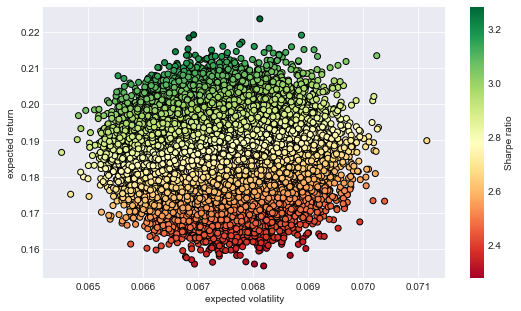

In [32]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(9, 5))
plt.scatter(portfolio_volatilities, portfolio_returns, c=sharpe_ratio,cmap='RdYlGn', edgecolors='black',marker='o') 
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')


In [33]:
from itertools import chain
returns_annual=list(chain.from_iterable(np.array(returns_annual)))

In [34]:
 # Markowitz找出最优投资组合
import scipy.optimize as sco
def statistics(weights):        
    weights = np.array(weights)
    pret = np.sum(returns_annual * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights):
    return -statistics(weights)[2]


In [35]:
np.set_printoptions(suppress=True)
bnds = tuple((0, 1) for x in range(number_assets))
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
opts = sco.minimize(min_func_sharpe, number_assets * [1. / number_assets,], method='SLSQP',  bounds=bnds, constraints=cons)
weights1=opts['x'].round(3)
print(weights1)  #得到各股票权重
print(statistics(weights1))  #得到投资组合预期收益率、预期波动率以及夏普比率

[0.009 0.009 0.    0.008 0.    0.    0.011 0.    0.002 0.007 0.002 0.
 0.    0.    0.001 0.002 0.    0.001 0.    0.009 0.001 0.005 0.004 0.
 0.    0.004 0.001 0.003 0.    0.002 0.002 0.001 0.004 0.006 0.002 0.
 0.    0.001 0.002 0.003 0.004 0.007 0.011 0.004 0.002 0.003 0.012 0.008
 0.002 0.001 0.006 0.003 0.015 0.012 0.015 0.004 0.001 0.007 0.005 0.005
 0.009 0.003 0.009 0.006 0.007 0.01  0.    0.    0.004 0.001 0.013 0.001
 0.002 0.001 0.    0.002 0.001 0.003 0.    0.003 0.002 0.003 0.006 0.001
 0.003 0.005 0.    0.003 0.004 0.    0.    0.007 0.007 0.001 0.    0.013
 0.003 0.001 0.    0.008 0.    0.003 0.    0.    0.    0.003 0.001 0.
 0.    0.001 0.001 0.003 0.    0.002 0.    0.004 0.001 0.001 0.    0.
 0.007 0.004 0.002 0.    0.    0.    0.004 0.001 0.    0.007 0.001 0.
 0.001 0.    0.009 0.002 0.001 0.007 0.003 0.002 0.    0.006 0.004 0.
 0.002 0.    0.001 0.001 0.003 0.003 0.    0.    0.    0.013 0.    0.
 0.004 0.005 0.006 0.009 0.    0.001 0.004 0.002 0.01  0.001 0.    0.
 0.00

In [36]:
#计算实际 real_return, real_cov
df=jq.get_money_flow(s, '2020-07-01', '2021-07-12', ['date','sec_code','change_pct'])
data=df.reset_index().pivot('date','sec_code','change_pct')
data.T

date,2020-07-01,2020-07-02,2020-07-03,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-13,2020-07-14,...,2021-06-29,2021-06-30,2021-07-01,2021-07-02,2021-07-05,2021-07-06,2021-07-07,2021-07-08,2021-07-09,2021-07-12
sec_code,,,,,,,,,,,,,,,,,,,,,
000009.XSHE,0.35,-0.59,0.82,4.56,4.47,0.11,0.64,9.98,7.53,-6.91,...,1.88,-0.65,-5.04,0.17,2.30,2.14,2.04,9.98,7.85,8.74
000012.XSHE,-1.01,2.86,0.79,4.72,-1.13,1.33,2.81,2.74,5.15,-2.20,...,-2.21,0.49,-1.66,4.07,0.95,-2.46,0.48,-5.21,-0.31,10.00
000021.XSHE,0.32,3.52,0.44,10.01,4.67,6.33,-0.79,1.41,1.64,-3.65,...,-3.04,3.35,-1.62,-2.66,2.02,-2.41,-1.15,1.16,-2.08,2.24
000027.XSHE,0.65,2.78,2.29,6.72,-0.57,1.54,0.76,6.94,7.02,-3.11,...,-5.57,-1.71,-3.82,-1.59,1.61,4.88,-2.27,0.44,0.88,-0.55
000028.XSHE,-0.18,0.38,3.55,1.95,0.29,0.10,2.01,-1.80,2.63,-0.90,...,-0.50,-0.03,1.19,-2.32,-1.84,-0.14,0.63,-1.76,0.41,-0.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601699.XSHG,1.97,4.23,8.95,6.98,-4.20,1.66,3.87,-5.44,1.67,7.60,...,-6.36,2.79,-1.78,1.90,3.55,2.04,-3.52,-9.96,1.20,0.36
601866.XSHG,1.09,2.69,5.24,7.46,-1.39,2.82,2.74,-4.00,2.31,-0.45,...,-2.42,3.31,-2.67,10.14,5.72,-2.35,0.72,-3.35,-1.24,-1.75
601872.XSHG,0.34,2.05,3.35,4.21,9.95,-0.71,1.85,-3.92,3.49,-2.53,...,-2.33,0.22,-4.33,3.85,0.65,1.73,-2.13,-3.26,-2.47,-2.76


In [37]:
real_return=[]
for i in range(len(s)):
    df=np.array(jq.get_price(s[i], '2020-07-01', '2021-07-12', 'daily',['close'],panel=False))
    r=(df[251]-df[0])/df[0]
    real_return.append(r[0])
    i=i+1 

In [38]:
real_return

[1.8061104582843712,
 1.2226804123711341,
 -0.15806451612903225,
 1.0021978021978022,
 -0.177085701295749,
 -0.3001949317738792,
 1.3328651685393256,
 -0.42359249329758714,
 0.03566710700132095,
 0.27882037533512055,
 0.24343506032647266,
 0.0025839793281653197,
 -0.22955523672883785,
 -0.282025819265144,
 -0.0037488284910964526,
 -0.03279938977879479,
 -0.26030769230769235,
 0.038216560509554034,
 -0.20538720538720548,
 0.7756410256410259,
 -0.04083861105044764,
 0.13144058885383808,
 0.2829581993569133,
 -0.27377521613832856,
 -0.17177914110429437,
 0.3148688046647229,
 0.08120133481646279,
 0.18976545842217477,
 -0.13550135501355015,
 0.07179487179487172,
 0.13815789473684228,
 -0.025128865979381364,
 0.21182266009852227,
 0.5408163265306123,
 0.2658140338748703,
 -0.3873417721518988,
 -0.2596599690880989,
 0.07407407407407408,
 -0.0376028202115159,
 0.12666666666666673,
 0.23232323232323232,
 0.22520107238605908,
 1.4654088050314464,
 0.21337579617834393,
 0.020188425302826427,
 0.

In [39]:
real_cov=np.array(data.corr())
real_cov

array([[1.        , 0.37916041, 0.29881728, ..., 0.19541081, 0.31221967,
        0.15036016],
       [0.37916041, 1.        , 0.28115719, ..., 0.25081019, 0.41820889,
        0.1556836 ],
       [0.29881728, 0.28115719, 1.        , ..., 0.33841113, 0.33628669,
        0.14243022],
       ...,
       [0.19541081, 0.25081019, 0.33841113, ..., 1.        , 0.43775008,
        0.24825866],
       [0.31221967, 0.41820889, 0.33628669, ..., 0.43775008, 1.        ,
        0.3726729 ],
       [0.15036016, 0.1556836 , 0.14243022, ..., 0.24825866, 0.3726729 ,
        1.        ]])

In [40]:
A=np.linalg.eigvals(real_cov)
if np.all(A>0):print('是正定矩阵') 
else:print('非正定矩阵') 

非正定矩阵


In [41]:
#实际资产相关矩阵优化
n=len(s)
data_g_test = real_cov
data_g_test = (data_g_test + data_g_test.transpose())/2.0 
data_g_test = data_g_test - np.diag(np.diag(data_g_test))  +np.eye(n)
b = np.ones((n, 1))
tau = 0
tol = 1.0e-6
[x_test_result, y_test_result] = my_correlationmatrix(data_g_test,b,tau,tol)

-- Semismooth Newton-CG method starts -- 

Newton-CG: Initial Dual objective function value: [[0.00277176]] 

Newton-CG: Initial Primal objective function value: 0.007956464118183647 

Newton-CG: Norm of Gradient: 0.024038604807579828 

Newton-CG: computing time used so far: 0.06245280000030107 

Newton-CG: Number of CG Iterations=== 2 

Newton-CG: The relative duality gap: [[0.00000337]] 

Newton-CG: The Dual objective function value: [[0.00313301]] 

Newton-CG: The Primal objective function value: 0.0031363937357589246 

Newton-CG: Norm of Gradient: 0.0005907006106415988 

Newton-CG: Norm of Relative Gradient: 3.255189418810544e-05 

Newton-CG: Computing time used so for 0.15251560000024256 

Newton-CG: Number of CG Iterations=== 2 

Newton-CG: The relative duality gap: [[0.]] 

Newton-CG: The Dual objective function value: [[0.00313324]] 

Newton-CG: The Primal objective function value: 0.0031332442475496547 

Newton-CG: Norm of Gradient: 1.1183832943185241e-06 

Newton-CG: Norm of 

In [42]:
np.set_printoptions(suppress=True)
real_cov=x_test_result
real_cov

array([[1.        , 0.3790957 , 0.29865298, ..., 0.19551961, 0.31208742,
        0.15035933],
       [0.3790957 , 1.        , 0.2813568 , ..., 0.2508376 , 0.41818329,
        0.15568634],
       [0.29865298, 0.2813568 , 1.        , ..., 0.33831435, 0.33624146,
        0.14295904],
       ...,
       [0.19551961, 0.2508376 , 0.33831435, ..., 1.        , 0.43767779,
        0.24794359],
       [0.31208742, 0.41818329, 0.33624146, ..., 0.43767779, 1.        ,
        0.37293362],
       [0.15035933, 0.15568634, 0.14295904, ..., 0.24794359, 0.37293362,
        1.        ]])

In [43]:
A=np.linalg.eigvals(real_cov)
if np.all(A>0):print('是正定矩阵') 
else:print('非正定矩阵') 

是正定矩阵


In [44]:
def real_result_compute(weights):        
    weights = np.array(weights)
    pret = np.sum(real_return * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(real_cov, weights)))
    return np.array([pret, pvol, pret / pvol]) #得到投资组合实际收益率、实际波动率以及夏普比率

In [45]:
Result=pd.DataFrame({'stock':c})
Result['p_weights']=opts['x'].round(3)
Result.set_index(['stock'],inplace=True)

In [46]:
Result

,p_weights
stock,
sz.000009,0.009
sz.000012,0.009
sz.000021,0.000
sz.000027,0.008
sz.000028,0.000
...,...
sh.601699,0.012
sh.601866,0.008
sh.601872,0.001


In [47]:
df=jq.get_price(s, '2020-07-01', '2021-07-12', 'daily',['close'],panel=False)
real_close_price=np.array(df.reset_index().pivot('time','code','close'))

In [48]:
real_close_price.shape

(252, 294)

In [49]:
print(real_result_compute(weights1))

[0.72740821 0.48264725 1.50712185]


Garch的Black-Litterman模型

In [50]:
df=jq.get_price(s[0], start_date, end_date, 'daily',['open','close','low','high'],panel=False)
df.index.name = 'date'

In [51]:
from datetime import datetime #导入datetime模块
df.index=pd.to_datetime(df.index) #转换数据格式
ts=df['open']
ts

date
2015-01-05     7.84
2015-01-06     7.84
2015-01-07     8.41
2015-01-08     8.07
2015-01-09     8.06
              ...  
2021-08-25    28.81
2021-08-26    28.80
2021-08-27    26.57
2021-08-30    27.52
2021-08-31    27.05
Name: open, Length: 1624, dtype: float64

In [52]:
testY=np.array(ts.iloc[2:])

In [53]:
from statsmodels.tsa.arima_model import ARIMA

In [54]:
model=ARIMA(ts,(1,1,0)) #白噪声检验通过，直接确定模型
result=model.fit()

D:\Downloads\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Downloads\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [55]:
pre=result.predict(dynamic=True,typ='levels')
pre

date
2015-01-07     7.851205
2015-01-08     7.862992
2015-01-09     7.874810
2015-01-12     7.886629
2015-01-13     7.898449
                ...    
2021-08-25    26.963168
2021-08-26    26.974987
2021-08-27    26.986806
2021-08-30    26.998626
2021-08-31    27.010445
Length: 1622, dtype: float64

In [56]:
predict_value=np.array(pre)

In [57]:
rms = np.sqrt(np.mean(np.power((testY - predict_value), 2)))
rms

11.773382945678225

In [58]:
def GARCH_fore(ts):
    ts=ts['close']
    ts=np.array(ts)
    model=ARIMA(ts,(1,1,0)) #白噪声检验通过，直接确定模型
    result=model.fit()
    pre=result.predict(dynamic=True,typ='levels')
    return pre

In [59]:
return_ARIMA=[]
for i in range(len(s)):
    df=jq.get_price(s[i], start_date, end_date, 'daily',['open','close','low','high'],panel=False)
    result=GARCH_fore(df)
    return_ARIMA.append((result[1585]-result[1333])/result[1333])
    i=i+1

In [60]:
return_ARIMA

[0.12838843750528514,
 0.08930254339712802,
 0.09377818914807537,
 0.04684820862503871,
 -0.046994727068546786,
 -0.1805045638615436,
 0.018395014773676974,
 -0.42101817671024167,
 -0.04820319851047057,
 -0.005862557923290875,
 0.054611008266454264,
 0.034013261488653246,
 0.00784894355811281,
 -0.2237299872856627,
 -0.01527108806704532,
 0.0019342896043019607,
 0.0064011552904594815,
 -0.07138100779600007,
 -0.18004937846195426,
 0.10046838539895156,
 0.10812061978462029,
 0.08081711519341953,
 -0.003068573615144379,
 -0.09811206178538133,
 -0.027446376838543014,
 0.045324811541196,
 -0.0588883390495864,
 -0.03852107994066537,
 -0.11225320293493586,
 0.013561021477701322,
 -0.03426829773501795,
 -0.07820745478398974,
 0.03347302543567495,
 0.03918420882746302,
 0.1234654781626662,
 0.03655408840526433,
 -0.017651262848548795,
 -0.028066246287687443,
 -0.13770490800934013,
 0.000569126327881491,
 -0.018813845201898348,
 0.0752139045507441,
 0.029987489521475574,
 0.12139499195786954,
 

In [61]:
r_expect=return_ARIMA
P = np.eye(len(r_expect))
Q = np.array(r_expect)
Q=Q.reshape(len(r_expect),1)

In [62]:
sh_return = pd.concat(y,axis=1)
res = blacklitterman(sh_return,0.1,P,Q)
p_mean = pd.DataFrame(res[0],index = sh_return.columns, columns = ['posterior_mean'])
p_cov = res[1]
print(p_mean)
print(p_cov)

           posterior_mean
sz.000009        0.092994
sz.000012        0.045833
sz.000021        0.057575
sz.000027       -0.013973
sz.000028       -0.003108
...                   ...
sh.601699        0.040975
sh.601866       -0.037933
sh.601872       -0.037354
sh.601958        0.013807
sh.601991       -0.081292

[294 rows x 1 columns]
[[ 0.00003421  0.00000262  0.00000196 ... -0.00000044  0.00000165
   0.00000023]
 [ 0.00000262  0.00002847  0.00000114 ...  0.00000025  0.00000077
  -0.00000015]
 [ 0.00000196  0.00000114  0.00003349 ...  0.00000049  0.00000001
  -0.00000031]
 ...
 [-0.00000044  0.00000025  0.00000049 ...  0.000025   -0.00000012
   0.00000045]
 [ 0.00000165  0.00000077  0.00000001 ... -0.00000012  0.00001594
   0.00000057]
 [ 0.00000023 -0.00000015 -0.00000031 ...  0.00000045  0.00000057
   0.00001351]]


In [63]:
A=np.linalg.eigvals(p_cov)
if np.all(A>0):print('是正定矩阵') 
else:print('非正定矩阵') 

非正定矩阵


In [64]:
n=len(s)
data_g_test = p_cov
data_g_test = (data_g_test + data_g_test.transpose())/2.0 
data_g_test = data_g_test - np.diag(np.diag(data_g_test))  +np.eye(n)
b = np.ones((n, 1))
tau = 0
tol = 1.0e-6
[x_test_result, y_test_result] = my_correlationmatrix(data_g_test,b,tau,tol)

-- Semismooth Newton-CG method starts -- 

Newton-CG: Initial Dual objective function value: [[0.]] 

Newton-CG: Initial Primal objective function value: 0.0 

Newton-CG: Norm of Gradient: 6.9039448873561286e-15 

Newton-CG: computing time used so far: 0.04012819999979911 



Newton-CG: Number of iterations: 0 

Newton-CG: Number of Funtion Evaluation:  =========== 1

Newton-CG: Final Dual Objective Function value: ========= [[0.]]

Newton-CG: Final Primal Objective Function value: ======= 0.0 

Newton-CG: The final relative duality gap: [[-0.]] 

Newton-CG: The rank of the Optimal Solution - tau*I: 294 

Newton-CG: computing time for computing preconditioners: 0 

Newton-CG: computing time for linear system solving (cgs time): 0 

Newton-CG: computing time for eigenvalue decompositions: =============== 0.02559960000007777 

Newton-CG: computing time used for equal weight calibration ============ 0.04286520000005112 



In [65]:
np.set_printoptions(suppress=True)
p_cov=x_test_result
p_cov

array([[ 1.        ,  0.00000262,  0.00000196, ..., -0.00000044,
         0.00000165,  0.00000023],
       [ 0.00000262,  1.        ,  0.00000114, ...,  0.00000025,
         0.00000077, -0.00000015],
       [ 0.00000196,  0.00000114,  1.        , ...,  0.00000049,
         0.00000001, -0.00000031],
       ...,
       [-0.00000044,  0.00000025,  0.00000049, ...,  1.        ,
        -0.00000012,  0.00000045],
       [ 0.00000165,  0.00000077,  0.00000001, ..., -0.00000012,
         1.        ,  0.00000057],
       [ 0.00000023, -0.00000015, -0.00000031, ...,  0.00000045,
         0.00000057,  1.        ]])

In [66]:
A=np.linalg.eigvals(p_cov)
if np.all(A>0):print('是正定矩阵') 
else:print('非正定矩阵') 

是正定矩阵


In [67]:
returns_annual = p_mean
cov_annual = p_cov

In [68]:
import scipy.optimize as sco
def statistics(weights):        
    weights = np.array(weights)
    pret = np.sum(returns_annual * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights):
    return -statistics(weights)[2]


In [69]:
from itertools import chain
returns_annual=list(chain.from_iterable(np.array(returns_annual)))

In [70]:
r_expect=returns_annual

In [71]:
number_assets = len(r_expect)
np.set_printoptions(suppress=True)
bnds = tuple((0, 1) for x in range(number_assets))
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
opts = sco.minimize(min_func_sharpe, number_assets * [1. / number_assets,], method='SLSQP',  bounds=bnds, constraints=cons)
weights2=opts['x'].round(3)
print(weights2)  #得到各股票权重
print(statistics(weights2))  #得到投资组合预期收益率、预期波动率以及夏普比率

[0.011 0.005 0.007 0.    0.    0.    0.    0.    0.003 0.004 0.005 0.
 0.    0.    0.001 0.    0.    0.    0.    0.009 0.007 0.005 0.002 0.
 0.    0.004 0.    0.    0.    0.001 0.    0.    0.001 0.003 0.011 0.
 0.    0.    0.    0.    0.001 0.007 0.001 0.008 0.    0.    0.015 0.005
 0.008 0.    0.    0.    0.009 0.005 0.013 0.    0.002 0.004 0.    0.006
 0.003 0.    0.012 0.001 0.006 0.006 0.    0.002 0.004 0.004 0.006 0.
 0.007 0.    0.001 0.003 0.001 0.    0.007 0.005 0.    0.    0.007 0.006
 0.007 0.009 0.    0.004 0.009 0.    0.005 0.012 0.014 0.    0.001 0.007
 0.009 0.007 0.009 0.004 0.003 0.013 0.    0.003 0.003 0.003 0.011 0.
 0.008 0.    0.011 0.007 0.    0.005 0.007 0.005 0.007 0.007 0.005 0.
 0.004 0.006 0.    0.008 0.006 0.008 0.004 0.005 0.002 0.012 0.008 0.
 0.    0.    0.003 0.    0.    0.    0.    0.    0.    0.004 0.001 0.
 0.    0.    0.    0.    0.001 0.002 0.    0.008 0.003 0.012 0.    0.
 0.    0.    0.012 0.002 0.006 0.    0.009 0.    0.005 0.006 0.005 0.
 0.006 0

In [72]:
Result=pd.DataFrame({'stock':c})
Result['p_weights']=opts['x'].round(3)
Result.set_index(['stock'],inplace=True)
Result

,p_weights
stock,
sz.000009,0.011
sz.000012,0.005
sz.000021,0.007
sz.000027,0.000
sz.000028,0.000
...,...
sh.601699,0.005
sh.601866,0.000
sh.601872,0.000


In [73]:
print(real_result_compute(weights2)) #得到投资组合实际收益率、实际波动率以及夏普比率

[0.45945962 0.47382605 0.96967996]


传统均值-方差模型

In [74]:
history_return=[]
for i in range(len(s)):
    df=np.array(jq.get_price(s[i], '2017-10-20', '2020-11-30', 'daily',['close'],panel=False))
    r=(((df[252]-df[0])/df[0])+((df[504]-df[252])/df[252])+((df[750]-df[500])/df[500]))/3
    history_return.append(r[0])
    i=i+1 

In [75]:
history_return

[0.12350322199826763,
 0.16173890595510054,
 0.483870521841209,
 0.04034837559476386,
 -0.07508363019202594,
 -0.07635877685645748,
 0.07126344253277077,
 -0.20114027552772482,
 -0.056696905823844714,
 -0.09666819552971868,
 -0.05400589498497669,
 0.03656828525403289,
 0.11791399133260129,
 -0.0674908968204405,
 -0.028142650556481883,
 0.11052421346588694,
 0.08505459546892918,
 -0.09658724421069735,
 -0.2402580844668619,
 -0.11521472130134196,
 0.2083922173822799,
 0.013693123165794205,
 0.05897919287233849,
 -0.17095572410585544,
 -0.1336480272650485,
 0.3668336279612245,
 -0.14000937647276,
 -0.1118544602109323,
 -0.03745145558281535,
 0.09411121513688873,
 -0.00977062989055428,
 -0.06457260743135876,
 -0.0567167979494888,
 -0.01219776931638287,
 0.7588686405515651,
 0.23854280406400133,
 0.047655519048906504,
 -0.021723917373391344,
 0.040245012904523564,
 0.015486405292090796,
 -0.18589920116650716,
 -0.07236678814143603,
 -0.05149790866629849,
 0.12217827347016845,
 -0.0154553117

In [76]:
#计算历史 history_return, history_cov
df=jq.get_money_flow(s, '2017-09-20', '2020-10-30', ['date','sec_code','change_pct'])
data=df.reset_index().pivot('date','sec_code','change_pct')

In [77]:
history_cov=np.array(data.corr())
history_cov

array([[1.        , 0.60145253, 0.50660087, ..., 0.29994807, 0.46036902,
        0.44330922],
       [0.60145253, 1.        , 0.5058653 , ..., 0.33559651, 0.52818308,
        0.49267685],
       [0.50660087, 0.5058653 , 1.        , ..., 0.24019255, 0.41841628,
        0.37840802],
       ...,
       [0.29994807, 0.33559651, 0.24019255, ..., 1.        , 0.33036041,
        0.37395109],
       [0.46036902, 0.52818308, 0.41841628, ..., 0.33036041, 1.        ,
        0.5293853 ],
       [0.44330922, 0.49267685, 0.37840802, ..., 0.37395109, 0.5293853 ,
        1.        ]])

In [78]:
A=np.linalg.eigvals(history_cov)
if np.all(A>0):print('Matrix is Symmetric Positive Definite') 
else:print('are not +ve definite') 

are not +ve definite


In [79]:
#历史收益协方差矩阵优化
n=len(s)
data_g_test = history_cov
data_g_test = (data_g_test + data_g_test.transpose())/2.0 
data_g_test = data_g_test - np.diag(np.diag(data_g_test))  +np.eye(n)
b = np.ones((n, 1))
tau = 0
tol = 1.0e-6
[x_test_result, y_test_result] = my_correlationmatrix(data_g_test,b,tau,tol)



-- Semismooth Newton-CG method starts -- 

Newton-CG: Initial Dual objective function value: [[0.03363443]] 

Newton-CG: Initial Primal objective function value: 0.07334810649427698 

Newton-CG: Norm of Gradient: 0.05629130887112402 

Newton-CG: computing time used so far: 0.038455099999737286 

Newton-CG: Number of CG Iterations=== 2 

Newton-CG: The relative duality gap: [[0.00001988]] 

Newton-CG: The Dual objective function value: [[0.03550755]] 

Newton-CG: The Primal objective function value: 0.03552884676830752 

Newton-CG: Norm of Gradient: 0.0013169395119957527 

Newton-CG: Norm of Relative Gradient: 7.25729326740635e-05 

Newton-CG: Computing time used so for 0.09866590000001452 

Newton-CG: Number of CG Iterations=== 2 

Newton-CG: The relative duality gap: [[0.]] 

Newton-CG: The Dual objective function value: [[0.03550868]] 

Newton-CG: The Primal objective function value: 0.0355086763910174 

Newton-CG: Norm of Gradient: 1.4158220620658319e-06 

Newton-CG: Norm of Relativ

In [80]:
np.set_printoptions(suppress=True)
history_cov=x_test_result
history_cov

array([[1.        , 0.601321  , 0.50656822, ..., 0.29979292, 0.46018788,
        0.443332  ],
       [0.601321  , 1.        , 0.50597642, ..., 0.33613846, 0.52856932,
        0.49258852],
       [0.50656822, 0.50597642, 1.        , ..., 0.24033946, 0.41842974,
        0.37845732],
       ...,
       [0.29979292, 0.33613846, 0.24033946, ..., 1.        , 0.33075113,
        0.37389249],
       [0.46018788, 0.52856932, 0.41842974, ..., 0.33075113, 1.        ,
        0.52905685],
       [0.443332  , 0.49258852, 0.37845732, ..., 0.37389249, 0.52905685,
        1.        ]])

In [81]:
A=np.linalg.eigvals(history_cov)
if np.all(A>0):print('Matrix is Symmetric Positive Definite') 
else:print('are not +ve definite') 

Matrix is Symmetric Positive Definite


In [82]:
 # Markowitz找出最优投资组合
import scipy.optimize as sco
def statistics(weights):        
    weights = np.array(weights)
    pret = np.sum(history_return * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(history_cov, weights)))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights):
    return -statistics(weights)[2]


In [83]:
np.set_printoptions(suppress=True)
bnds = tuple((0, 1) for x in range(number_assets))
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
opts = sco.minimize(min_func_sharpe, number_assets * [1. / number_assets,], method='SLSQP',  bounds=bnds, constraints=cons)
weights3=opts['x'].round(3)
print(weights3)  #得到各股票权重
print(statistics(weights3))  #得到投资组合预期收益率、预期波动率以及夏普比率

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.092 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.114 0.    0.    0.    0.    0.
 0.    0.088 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.013 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0

In [84]:
print(real_result_compute(weights3)) #得到投资组合实际收益率、实际波动率以及夏普比率

[0.51205989 0.53879587 0.95037827]


等权重模型

In [85]:
matrix=[1/len(s) for i in range(len(s))]
weights4=matrix
print(weights4)

[0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.003401360544217687, 0.0034013

In [86]:
print(real_result_compute(weights4)) #得到投资组合实际收益率、实际波动率以及夏普比率

[0.20918361 0.47505    0.44034019]


4种方法回测情况

In [87]:
def MaxDrawdown(return_list):
    i = np.argmax((np.maximum.accumulate(return_list)- return_list)/np.maximum.accumulate(return_list))
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])
    return(return_list[j] - return_list[i]) / return_list[j]

In [88]:
series1=np.dot(real_close_price,(weights1/real_close_price[0])) #LSTM+Black-litterman
series2=np.dot(real_close_price,(weights2/real_close_price[0])) #GARCH+Black-litterman
series3=np.dot(real_close_price,(weights3/real_close_price[0])) #Markowitz Mean-Variance
series4=np.dot(real_close_price,(weights4/real_close_price[0])) #Equal weights

In [89]:
print(real_result_compute(weights1),MaxDrawdown(series1))
print(real_result_compute(weights2),MaxDrawdown(series2))
print(real_result_compute(weights3),MaxDrawdown(series3))
print(real_result_compute(weights4),MaxDrawdown(series4))
#得到投资组合实际收益率、实际波动率以及夏普比率,最大回撤

[0.72740821 0.48264725 1.50712185] 0.09003105592057305
[0.45945962 0.47382605 0.96967996] 0.1095923020625804
[0.51205989 0.53879587 0.95037827] 0.21343460240213438
[0.20918361 0.47505    0.44034019] 0.1324603145888779


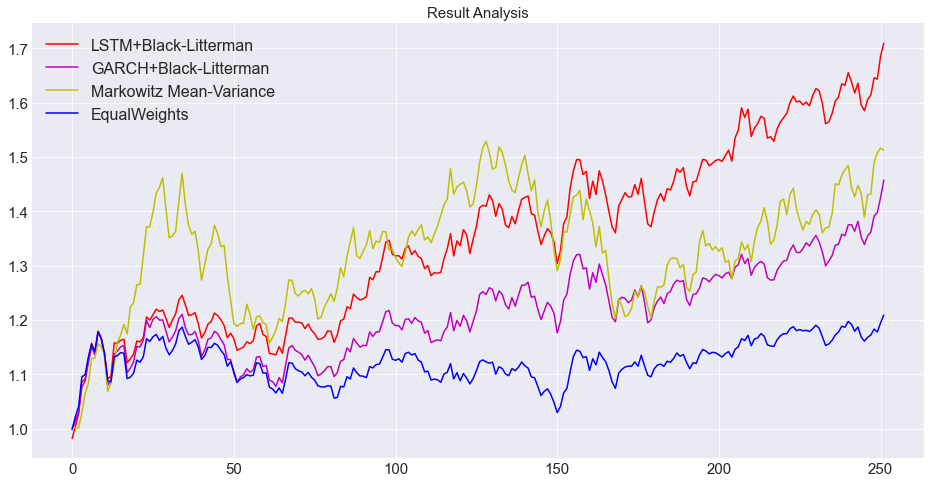

In [90]:
plt.figure(figsize=(16,8))
plt.title('Result Analysis',size=15)
plt.plot(series1, color='red', label='LSTM+Black-Litterman')
plt.plot(series2,  color='m', label='GARCH+Black-Litterman')
plt.plot(series3,  color='y', label='Markowitz Mean-Variance')
plt.plot(series4,  color='blue', label='EqualWeights')
plt.tick_params(labelsize=15)
plt.grid()
plt.legend(fontsize=16)